In [ ]:
#Reference: https://towardsdatascience.com/image-feature-extraction-using-pytorch-e3b327c3607a
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

# **Import Drive**

In [ ]:

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Path to Aerial Dataset**
(A combination of samples from Small Village and Industrial Datasets from Sensefly)

In [ ]:
aerial_path = '/content/drive/MyDrive/Comb_small_village_tech_park'

# **Aerial Dataset Class**

In [ ]:
class AerialData(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.labels_path = self.root_dir+'/train_challenge.csv'
    self.transform = transform
    self.all_imgs_dir = os.listdir(self.root_dir)


  def __len__(self):



    return len(self.all_imgs_dir)
    
  
  def __getitem__(self,index):
    #index+=1
    if torch.is_tensor(index):
      index = index.tolist()
    #print(index)



    try:
      img_loc = os.path.join(self.root_dir, self.all_imgs_dir[index])
      img_name = img_loc.split('/')[-1]
    except FileNotFoundError:
      pass


    #print(img_name)
    #print(ok)
    image = io.imread(img_loc,as_gray=False)
    #print(image.shape)

    if self.transform:
      image = self.transform(image)

    sample = {'image': image, 'name':img_name}

    #print(sample['label'])
    #plt.imshow(sample['image'])
    #plt.show()

    return sample

# **Dataset and Dataloader initialization**

In [ ]:
#Pre processing the data
normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                std = [0.229,0.224,0.225])
resize = transforms.Resize((224,224))



preprocessor = transforms.Compose([ transforms.ToPILImage(),resize,transforms.ToTensor(),normalize
                                   ])

aerial_dataset_full = AerialData(root_dir= aerial_path, transform=preprocessor)


aerial_dataloader = DataLoader(aerial_dataset_full, batch_size=1, shuffle=False)


In [ ]:
print(len(aerial_dataset_full))

69


In [ ]:
print(aerial_dataset_full[0])

{'image': tensor([[[ 0.0398,  0.1083, -0.0629,  ..., -0.2513, -0.2513, -0.2856],
         [ 0.0398, -0.0116, -0.0801,  ..., -0.2171, -0.2342, -0.2342],
         [ 0.0569,  0.0056, -0.0972,  ..., -0.1657, -0.2171, -0.2513],
         ...,
         [-0.9877, -0.8335, -0.6965,  ..., -0.3369, -0.3027, -0.2513],
         [-0.9020, -0.7993, -0.7308,  ..., -0.4054, -0.2342, -0.1828],
         [-0.9192, -0.7822, -0.6965,  ..., -0.5253, -0.3369, -0.2342]],

        [[ 0.3452,  0.4328,  0.2752,  ..., -0.0224, -0.0049, -0.0399],
         [ 0.3452,  0.3102,  0.2577,  ...,  0.0301, -0.0049, -0.0224],
         [ 0.3803,  0.3452,  0.2752,  ...,  0.0651,  0.0126, -0.0224],
         ...,
         [-0.8102, -0.6527, -0.5651,  ..., -0.4251, -0.3725, -0.3375],
         [-0.7577, -0.6176, -0.5826,  ..., -0.4426, -0.2850, -0.2325],
         [-0.7577, -0.6352, -0.5651,  ..., -0.4601, -0.3375, -0.3025]],

        [[ 0.6705,  0.7751,  0.6705,  ...,  0.3393,  0.3219,  0.3219],
         [ 0.6705,  0.6879,  0.6705

In [ ]:
#use_gpu = torch.cuda.is_available()

#model = torchvision.models.vgg16(pretrained=True)
#feature_extractor = nn.Sequential(*list(model.classifier.children())[:-1]) #Remove FC layer
#model.classifier = feature_extractor

# **Feature Extractor**
(Replaces classifier layer from pretrained VGG16 with the first layer of the same classifier)

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 



# **Model Initialization**

In [ ]:
# Initialize the model
model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [ ]:
gpu_flag = torch.cuda.is_available()
print(gpu_flag)
if gpu_flag:
    new_model = new_model.cuda()

False


In [ ]:
print(new_model)

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [ ]:

tqdm = partial(tqdm, position=0, leave=True)

# **Extracting the Feature Embeddings from each image**

In [ ]:
features_embeddings = []
#set model in evaluation mode
new_model.eval()

for i, sample in enumerate(tqdm(aerial_dataloader)):
  with torch.no_grad():

      if gpu_flag:
            x_var = Variable(sample['image']).cuda()
      else:
            x_var = Variable(sample['image'])
      x_var_feat = new_model(x_var)
      #print(sample['name'])
      feature_arr = x_var_feat.cpu().numpy().copy()

      features_embeddings.append(feature_arr)



100%|██████████| 69/69 [02:48<00:00,  2.45s/it]


In [ ]:
features_embeddings = np.array(features_embeddings)
features_embeddings = features_embeddings.reshape(features_embeddings.shape[0],features_embeddings.shape[2])

# **Clustering into 2 using KMeans**

In [ ]:

num_clusters  =2
# Initialize the model
model = KMeans(n_clusters=num_clusters, random_state=1)

# Fit the data into the model
model.fit(features_embeddings)

# Extract the labels
predicted_labels = model.labels_

#print(labels) # [4 3 3 ... 0 0 0]

In [ ]:
actual_labels = [0]*32 + [1]*37 # Actual Labels

In [ ]:
print('Completeness Score:',completeness_score(actual_labels, predicted_labels))  #How good the algorithm performs on the dataset w.r.t assigning clusters

0.8101150683190305


# **Plotting samples of correct (67/69) and incorrect (2/69) predictions**

In [ ]:
samples_correct_predicted = np.where(actual_labels==predicted_labels)[0]

In [ ]:
random_samples = random.sample(list(samples_correct_predicted),5)

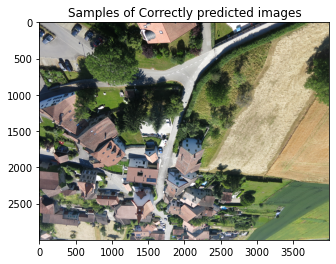

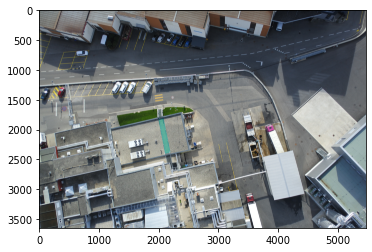

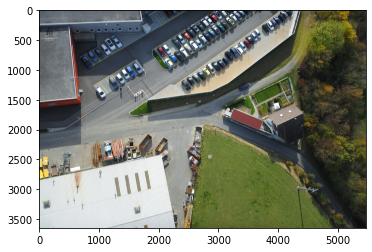

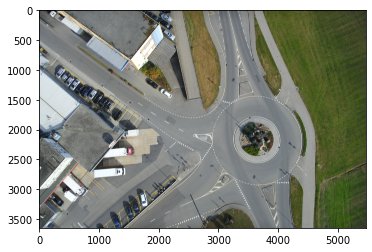

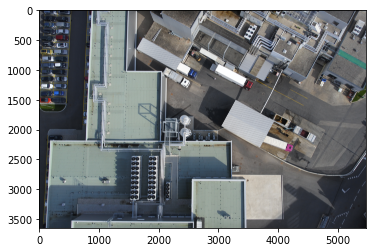

In [ ]:

plt.title('Samples of Correctly clustered images')

for index in random_samples:
  img_path = os.path.join(aerial_path, os.listdir(aerial_path)[index])
  img = io.imread(img_path, as_gray=False)
  plt.imshow(img)
  plt.show()

In [ ]:
samples_incorrect_predicted = np.where(actual_labels!=predicted_labels)[0] #Incorrect Predictions

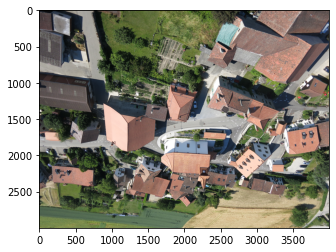

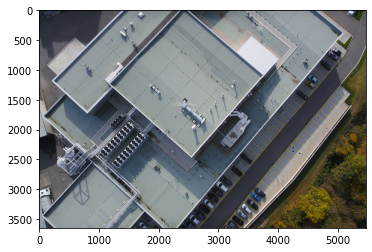

In [ ]:
plt.title('Incorrect cluster predictions')

for index in samples_incorrect_predicted:
  img_path = os.path.join(aerial_path, os.listdir(aerial_path)[index])
  img = io.imread(img_path, as_gray=False)
  plt.imshow(img)
  plt.show()

In [ ]:
print(model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)


# **Observation**

Worked well, but can be improved through maybe training using a triplet-loss especially in-cases where vegetation is mixed between industrial/village regions, which is confusing the model. 